https://www.alpha-i.co/blog/MNIST-for-ML-beginners-The-Bayesian-Way.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd
ed.set_seed(314159)

In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
total = mnist.train.num_examples #number of training examples
N = total/10   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 50    # number of neurons.

In [4]:
#two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return h

def display_draws(loss, train_x, EPOCH_NUM):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    plt.plot(np.arange(EPOCH_NUM), loss / len(train_x), label='Train')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('ELBO', fontsize=15)
    plt.show()

In [5]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))

In [6]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [7]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

In [8]:
learning_rate = 5e-6
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

In [8]:
#inference.initialize(optimizer=optimizer,n_iter=5000,n_print=100, scale={y: float(total) / N})
inference.initialize(n_iter=5000,n_print=100, scale={y: float(total) / N})

In [9]:
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [10]:
epoch_num = 200
train_lossbb = np.zeros(epoch_num)

In [11]:
for epoch in range(epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossbb[epoch] = info_dict['loss']
    inference.print_progress(info_dict)

2000/5000 [ 40%] ████████████                   ETA: 116s | Loss: 22174.6914

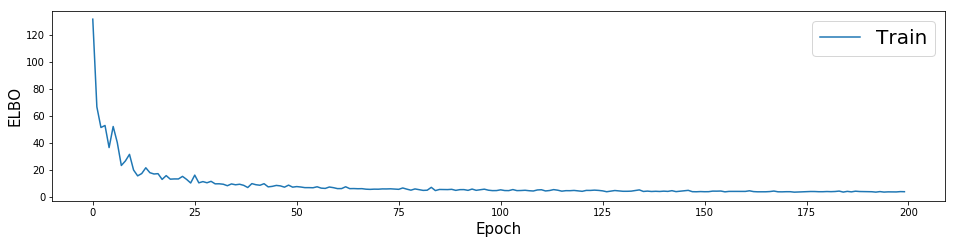

In [12]:
display_draws(train_lossbb, X_batch, epoch_num)

# Evaluate the model Big Batch

In [13]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

In [14]:
# Generate samples from the posterior and store them.
n_samples = 10
prob_lst = []
samples = []
w0_samples = []
b0_samples = []
w1_samples = []
b1_samples = []
for _ in range(n_samples):
    w0_samp = qw0.sample()
    b0_samp = qb0.sample()
    w0_samples.append(w0_samp)
    b0_samples.append(b0_samp)
    
    w1_samp = qw1.sample()
    b1_samp = qb1.sample()
    w1_samples.append(w1_samp)
    b1_samples.append(b1_samp)
    
    # Also compue the probabiliy of each class for each (w,b) sample.
    h=tf.matmul( X_test,w0_samp ) + b0_samp
    prob = tf.nn.softmax(tf.matmul( h,w1_samp ) + b1_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w0_samp,[-1]),tf.reshape(w1_samp,[-1]),b0_samp,b1_samp],0)
    samples.append(sample.eval())

In [15]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

('accuracy in predicting the test data = ', 75.349999999999994)


('truth = ', 7)


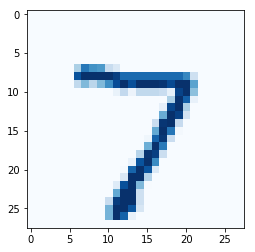

In [16]:
# Load the first image from the test data and its label.
test_image = X_test[0:1]
test_label = Y_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

In [17]:
# Now the check what the model perdicts for each (w,b) sample from the posterior. This may take a few seconds...
sing_img_probs = []
for w0_samp,w1_samp,b0_samp,b1_samp in zip(w0_samples,w1_samples,b0_samples,b1_samples):
    h=tf.matmul( X_test[0:1],w0_samp ) + b0_samp
    prob = tf.nn.softmax(tf.matmul( h,w1_samp ) + b1_samp)
    sing_img_probs.append(prob.eval())

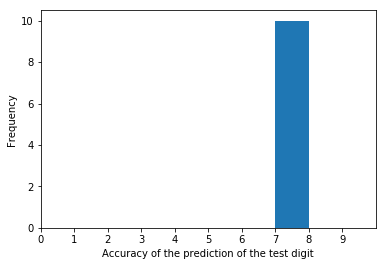

In [18]:
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")

# KL Optim Small Batch

In [20]:
N = total/100   # number of images in a minibatch.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})
# Initialse the infernce variables
#inference.initialize(optimizer=optimizer,n_iter=5000,n_print=100, scale={y: float(total) / N})
inference.initialize(n_iter=5000,n_print=100, scale={y: float(total) / N})
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
train_losssb = np.zeros(epoch_num)

for epoch in range(epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_losssb[epoch] = info_dict['loss']
    # inference.print_progress(info_dict)

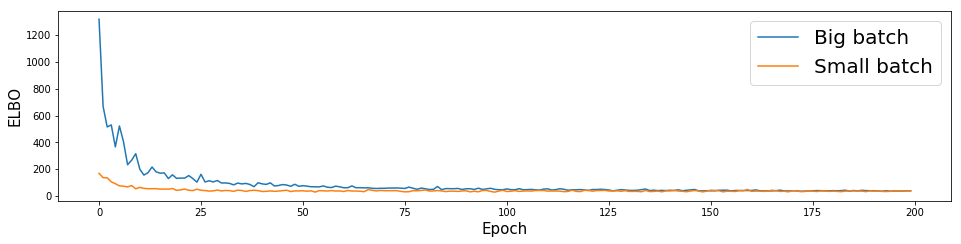

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(epoch_num), train_lossbb / len(X_batch), label='Big batch')
plt.plot(np.arange(epoch_num), train_losssb / len(X_batch), label='Small batch')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('ELBO', fontsize=15)
plt.show()

# Evaluate the model Small Batch

In [22]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

In [23]:
# Generate samples from the posterior and store them.
n_samples = 10
prob_lst = []
samples = []
w0_samples = []
b0_samples = []
w1_samples = []
b1_samples = []
for _ in range(n_samples):
    w0_samp = qw0.sample()
    b0_samp = qb0.sample()
    w0_samples.append(w0_samp)
    b0_samples.append(b0_samp)
    
    w1_samp = qw1.sample()
    b1_samp = qb1.sample()
    w1_samples.append(w1_samp)
    b1_samples.append(b1_samp)
    
    # Also compue the probabiliy of each class for each (w,b) sample.
    h=tf.matmul( X_test,w0_samp ) + b0_samp
    prob = tf.nn.softmax(tf.matmul( h,w1_samp ) + b1_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w0_samp,[-1]),tf.reshape(w1_samp,[-1]),b0_samp,b1_samp],0)
    samples.append(sample.eval())

In [24]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

('accuracy in predicting the test data = ', 77.100000000000009)


('truth = ', 7)


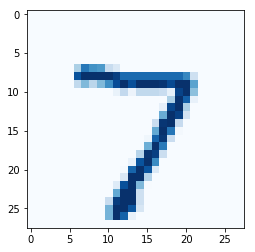

In [25]:
# Load the first image from the test data and its label.
test_image = X_test[0:1]
test_label = Y_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

In [26]:
# Now the check what the model perdicts for each (w,b) sample from the posterior. This may take a few seconds...
sing_img_probs = []
for w0_samp,w1_samp,b0_samp,b1_samp in zip(w0_samples,w1_samples,b0_samples,b1_samples):
    h=tf.matmul( X_test[0:1],w0_samp ) + b0_samp
    prob = tf.nn.softmax(tf.matmul( h,w1_samp ) + b1_samp)
    sing_img_probs.append(prob.eval())

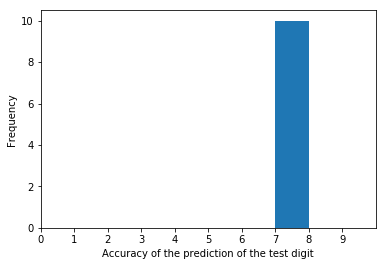

In [27]:
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")